# Visualize Networks

In [1]:
import graph_tool.all as gt
import graph_tool.draw as gtd
from graph_tool.stats import vertex_hist
import numpy as np
import pickle

In [2]:
# Load the graph
g = gt.load_graph("/mnt/disk2/Data/3_Day_Graphs/2021-05-01.graphml")
g

<Graph object, directed, with 36886 vertices and 466447 edges, 4 internal vertex properties, 2 internal edge properties, at 0x7f7f6fddfad0>

In [3]:
#pos_fruchterman_reingold Layout
pos_fruchterman_reingold = gt.fruchterman_reingold_layout(g)
#pos_sfdp = gtd.sfdp_layout(g)

In [15]:
with open("/mnt/disk2/Data/Pickle/pos_fruchterman_reingold.pkl", "wb") as f:
    pickle.dump(pos_fruchterman_reingold, f)

In [ ]:
# Assign colors based on 'Political Affiliation'
color_dict = {
    'No Retweets': [0.5, 0.5, 0.5, 1],        # Gray for 'No Retweets'
    'Retweets Centro': [0, 1, 0, 1],          # Green for 'Retweets Centro'
    'Retweets Derecha': [1, 0, 0, 1],         # Red for 'Retweets Derecha'
    'Retweets Izquierda': [0, 0, 1, 1],       # Blue for 'Retweets Izquierda'
}

In [ ]:
# Get vertex colors from the dictionary
# vertex_colors = g.new_vertex_property('vector<double>')
# for v in g.vertices():
#     affiliation = g.vertex_properties["Political Affiliation"][v]
#     vertex_colors[v] = color_dict.get(affiliation, [0.5, 0.5, 0.5, 1])  # Default to gray if not found

# Node Size based on Degree (influenced by edge weights)
hist, _ = vertex_hist(g, "total")
max_size = 25
min_size = 5
vertex_sizes = g.new_vertex_property('double')
size_factor = (hist - hist.min()) / (hist.max() - hist.min())
vertex_sizes.a = size_factor * (max_size - min_size) + min_size

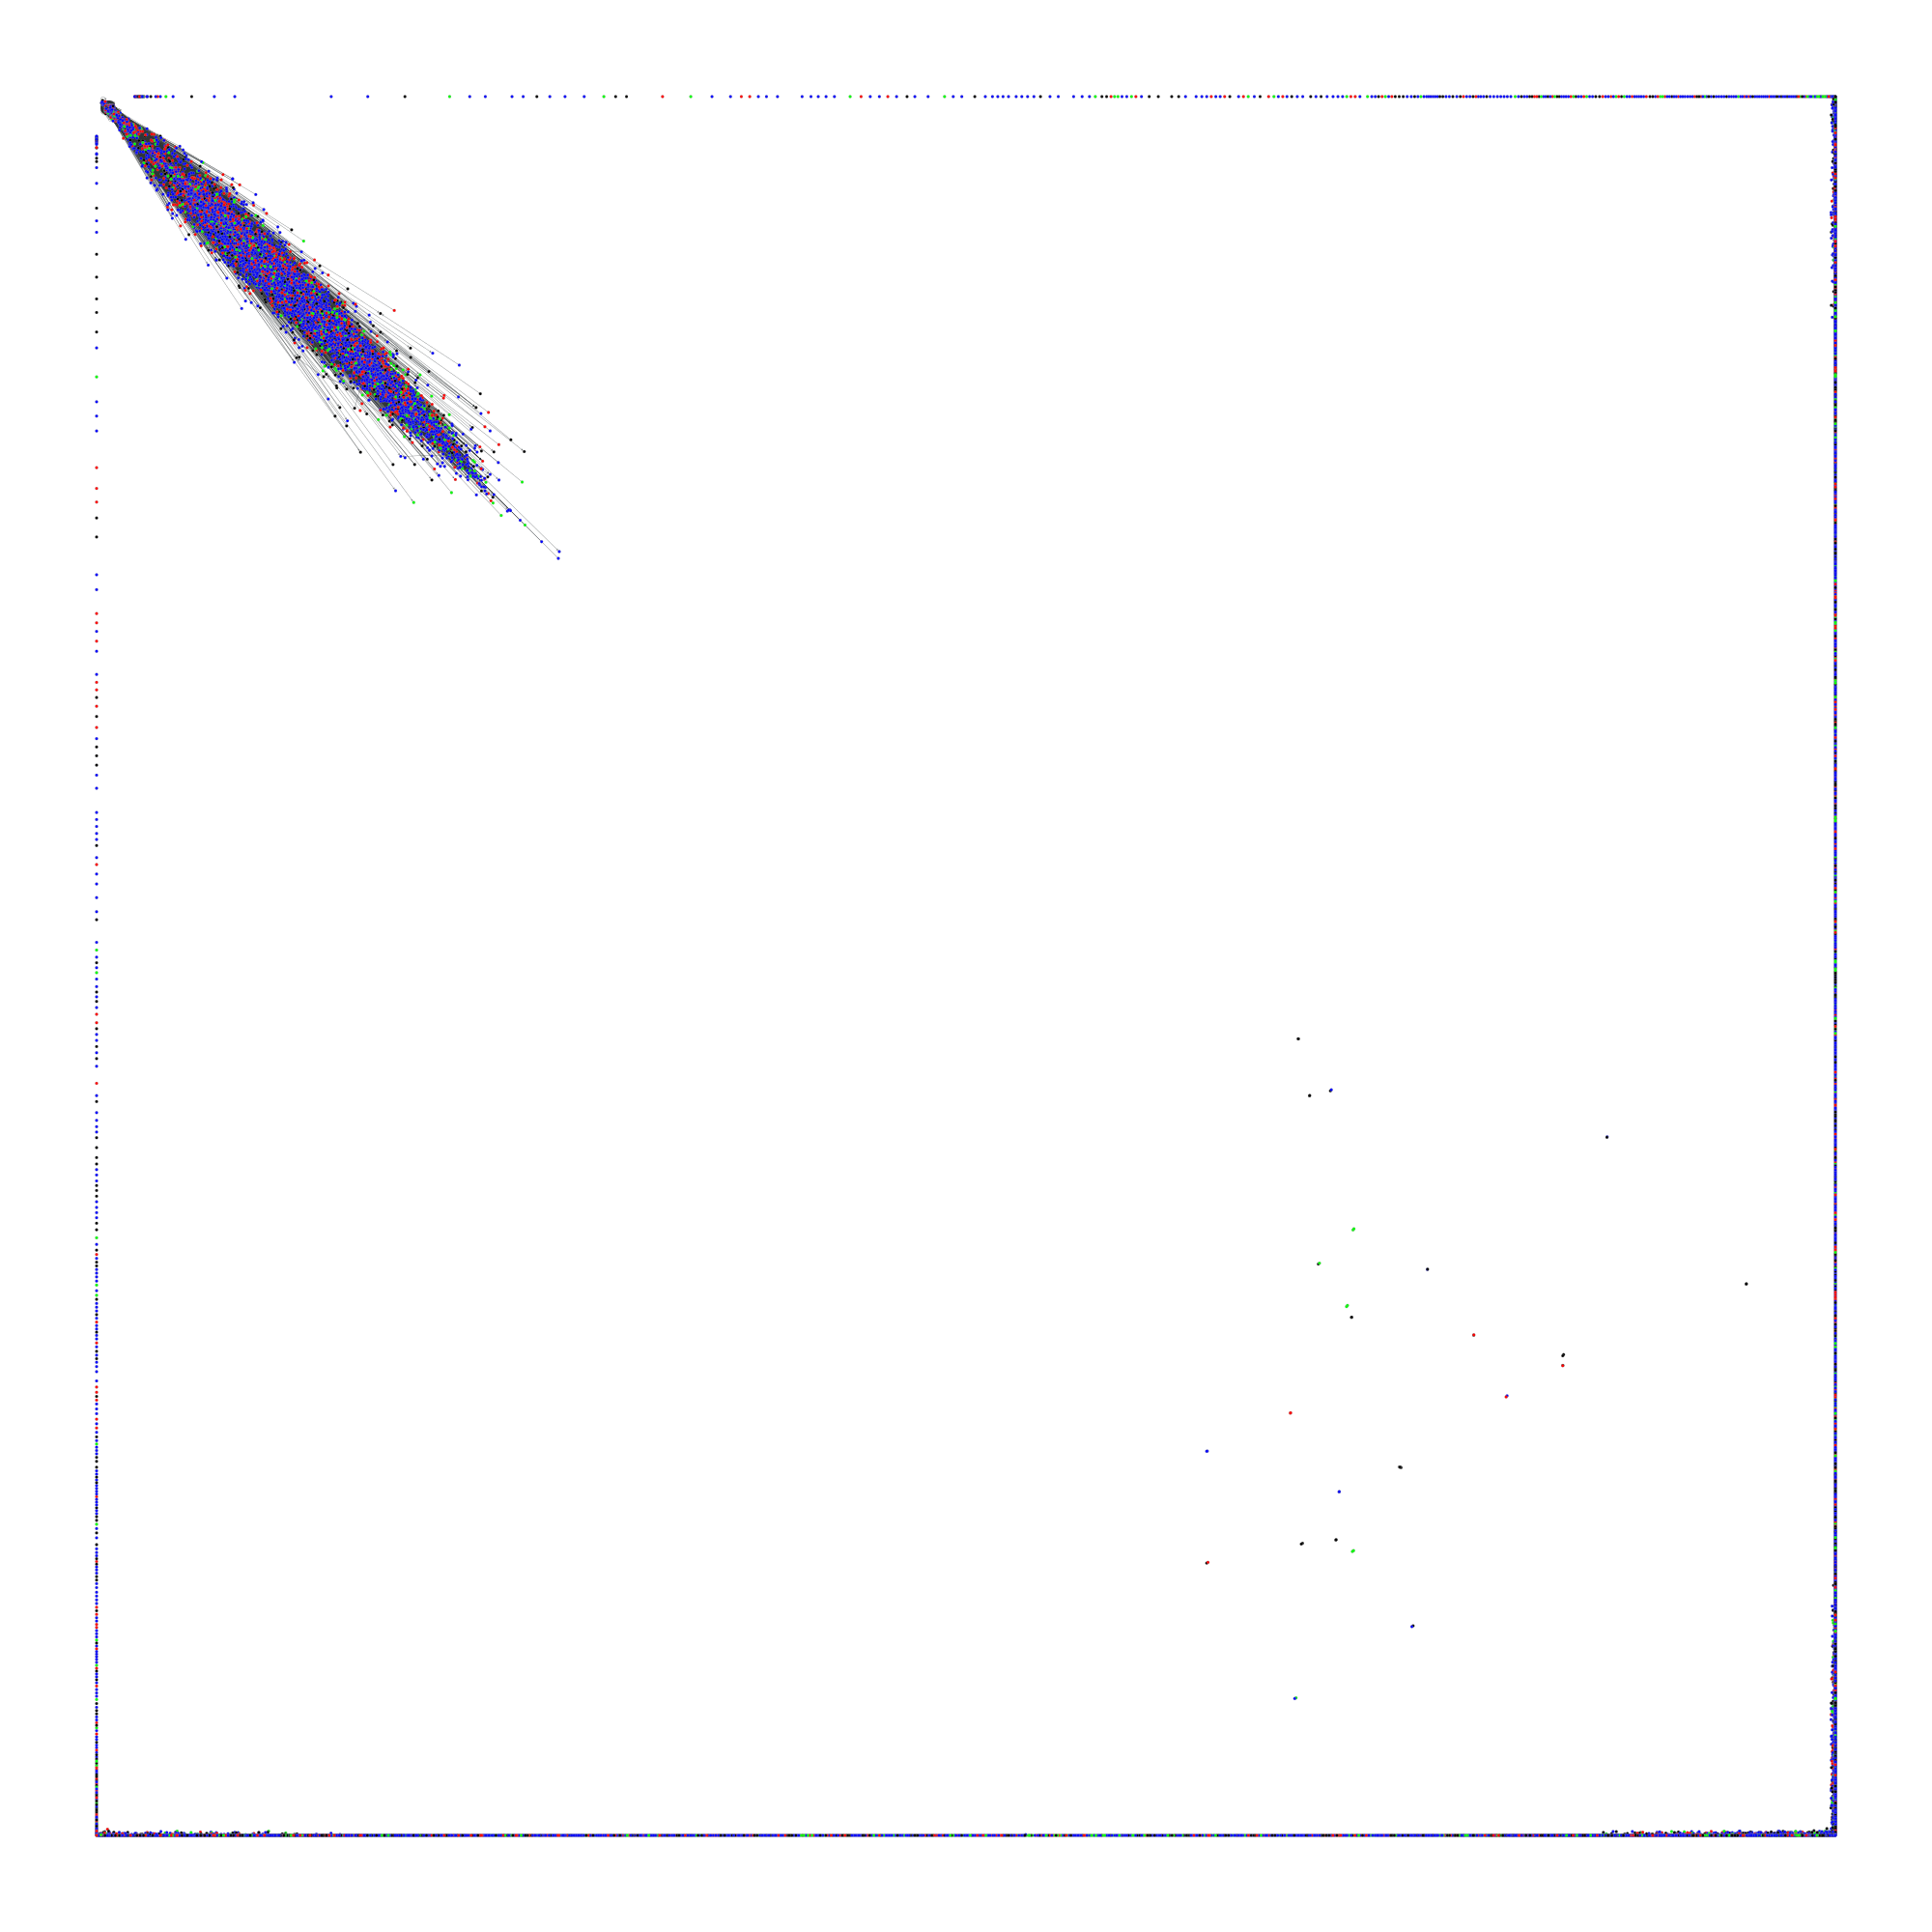

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f7f6fddfad0, at 0x7f802e80ba10>

In [12]:
# Draw the graph
gt.graph_draw(g, pos_fruchterman_reingold, vertex_fill_color = g.vp['Color'], output_size = (1000, 1000))